# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier, plot_importance

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

d:\anaconda3\envs\cnn\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

In [6]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 1044078, 844179, 1046545]

In [7]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 1079023, 847962, 873980]

In [8]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1042907, 1044078, 1046587, 10355376]

In [9]:
recommender.get_similar_users_recommendation(2375, N=5)

[1029743, 1106523, 5569230, 916122, 844179]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [11]:
cold_users = np.setdiff1d(result_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()
result_lvl_1 = result_lvl_1[~result_lvl_1['user_id'].isin(cold_users)]

In [12]:
%%time
def get_rec(result_lvl_1, N=200):
    result_lvl_1['als_rec'] = result_lvl_1['user_id'].progress_apply(lambda x: recommender.get_als_recommendations(x, N=N))
    result_lvl_1['own_rec'] = result_lvl_1['user_id'].progress_apply(lambda x: recommender.get_own_recommendations(x, N=N))

    result_lvl_1['sim_items_rec'] = result_lvl_1['user_id'].progress_apply\
                (lambda x: recommender.get_similar_items_recommendation(x, N=N))
    return result_lvl_1

result_lvl_1 = get_rec(result_lvl_1, N=200)
result_lvl_1['sim_users_rec'] = result_lvl_1['user_id'].progress_apply\
            (lambda x: recommender.get_similar_users_recommendation(x, N=200))

result_lvl_1.head(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2151/2151 [00:00<00:00, 7580.73it/s]

Wall time: 45 s


,user_id,actual,als_rec,own_rec,sim_items_rec,sim_users_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[15596112, 885290, 953539, 1060193, 9834742, 9...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[1045586, 1007512, 9297615, 5577022, 907002, 9...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[916122, 866102, 1051211, 1058404, 1029743, 86...","[911974, 1076580, 5567582, 1103898, 1056620, 9...","[8090537, 1044078, 5569845, 880888, 985999, 81...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[6391541, 846502, 1052294, 987044, 1137010, 82...","[6391541, 1052294, 891423, 936470, 1137010, 11...","[930137, 846550, 8069118, 7025094, 977658, 110...","[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [13]:
for col in result_lvl_1.iloc[:,2:]:
    print(col +": ","{0:.4f}".format(result_lvl_1.apply(lambda row: precision_at_k(row[col], row['actual'], k=5), axis=1).mean()))

als_rec:  0.1267
own_rec:  0.1771
sim_items_rec:  0.0617
sim_users_rec:  0.1306


In [14]:
ks = [i for i in range(10, 500, 10)]
rec_types = result_lvl_1.columns.drop(['user_id','actual'])

recall_df = pd.DataFrame(index=ks, columns=rec_types)
for rec_type in rec_types:
    for k in ks:
        recall_value = result_lvl_1.apply(lambda row: recall_at_k(row[rec_type], row['actual'], k=k), axis=1).mean()
        recall_df.loc[k, rec_type] = recall_value

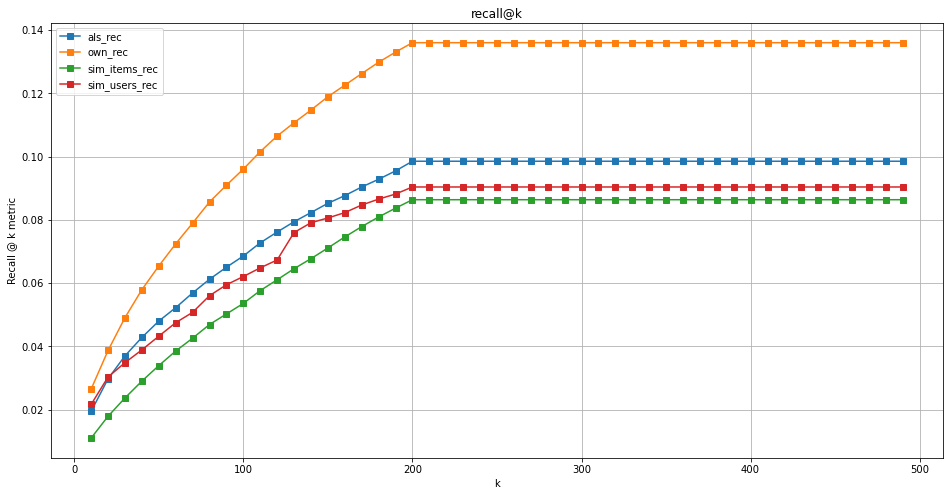

In [15]:
recall_df.plot(figsize=(16,8), marker='s')
plt.title('recall@k')
plt.xlabel('k')
plt.ylabel('Recall @ k metric')
plt.grid(True)
plt.show()

In [16]:
def train_test_preprocessing(data):
    """Подготовка обучающего и валидационного датасетов, разбиение на X и y"""
    
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())

    users_lvl_2.columns = ['user_id']

    
    train_users = data_train_lvl_1['user_id'].unique() 
    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

    # Рекомендации на основе собственных покупок
    users_lvl_2_ = users_lvl_2.copy()
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(
        lambda x: recommender.get_own_recommendations(x, N=200)
    )

    s = users_lvl_2.apply(
        lambda x: pd.Series(x['candidates']), axis=1
    ).stack().reset_index(level=1, drop=True)

    s.name = 'item_id'

    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)


    users_lvl_2['flag'] = 1

    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2.head(2)

    targets_lvl_2['target'] = 1  # тут только покупки

    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)

   
    return targets_lvl_2

In [17]:
target = train_test_preprocessing(data_train_lvl_2)

In [18]:
target.head(3)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,948640,0.0


### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [19]:
def new_features(data, item_features, user_features):
    """Новые признаки для продуктов"""
    
    new_item_features = item_features.merge(data, on='item_id', how='left')
  

    # Количество продаж и среднее количество продаж товара

    item_qnt = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
    item_qnt.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)

    item_qnt['quantity_of_sales_per_week'] = item_qnt['quantity_of_sales'] / new_item_features['week_no'].nunique()

    item_features = item_features.merge(item_qnt, on='item_id')

    # Среднее количество продаж товара в категории в неделю

    items_in_department = new_item_features.groupby('department')['item_id'].count().reset_index().sort_values(
        'item_id', ascending=False
    )
    items_in_department.rename(columns={'item_id': 'items_in_department'}, inplace=True)

    qnt_of_sales_per_dep = new_item_features.groupby(['department'])['quantity'].count().reset_index().sort_values(
        'quantity', ascending=False
    )
    qnt_of_sales_per_dep.rename(columns={'quantity': 'qnt_of_sales_per_dep'}, inplace=True)


    items_in_department = items_in_department.merge(qnt_of_sales_per_dep, on='department')
    items_in_department['qnt_of_sales_per_item_per_dep_per_week'] = (
        items_in_department['qnt_of_sales_per_dep'] / 
        items_in_department['items_in_department'] / 
        new_item_features['week_no'].nunique()
    )
    items_in_department = items_in_department.drop(['items_in_department'], axis=1)

    item_features = item_features.merge(items_in_department, on=['department'], how='left')
    
    # Средний чек в категории
    category_mean_price = new_item_features.groupby(['department'])['sales_value'].mean().reset_index()
    category_mean_price.rename(columns={'sales_value': 'mean_sales_value_category'}, inplace=True)
    item_features = new_item_features.merge(category_mean_price, on='department')
    item_features['category_mean_price'] = item_features['sales_value']/item_features['mean_sales_value_category']
    item_features = item_features.drop(['mean_sales_value_category'], axis=1)
    
   
    ###########################################################################################################
    """Новые признаки для пользователей"""
    
    new_user_features = user_features.merge(data, on='user_id', how='left')


    ##### Возраст
    user_features['age'] = user_features['age_desc'].replace(
        {'65+': 70, '45-54': 50, '25-34': 30, '35-44': 40, '19-24':20, '55-64':60}
    )
    user_features = user_features.drop('age_desc', axis=1)

    ##### Доход
    user_features['income'] = user_features['income_desc'].replace(
        {'35-49K': 45,
     '50-74K': 70,
     '25-34K': 30,
     '75-99K': 95,
     'Under 15K': 15,
     '100-124K': 120,
     '15-24K': 20,
     '125-149K': 145,
     '150-174K': 170,
     '250K+': 250,
     '175-199K': 195,
     '200-249K': 245}
    )
    user_features = user_features.drop('income_desc', axis=1)

    ##### Дети
    user_features['kids'] = 0
    user_features.loc[(user_features['kid_category_desc'] == '1'), 'kids'] = 1
    user_features.loc[(user_features['kid_category_desc'] == '2'), 'kids'] = 2
    user_features.loc[(user_features['kid_category_desc'] == '3'), 'kids'] = 3
    user_features = user_features.drop('kid_category_desc', axis=1)

    ##### Средний чек, средний чек в неделю
    basket = new_user_features.groupby(['user_id'])['sales_value'].sum().reset_index()

    baskets_qnt = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
    baskets_qnt.rename(columns={'basket_id': 'baskets_qnt'}, inplace=True)

    average_basket = basket.merge(baskets_qnt)

    average_basket['average_basket'] = average_basket.sales_value / average_basket.baskets_qnt
    average_basket['sum_per_week'] = average_basket.sales_value / new_user_features.week_no.nunique()

    average_basket = average_basket.drop(['sales_value', 'baskets_qnt'], axis=1)

    user_features = user_features.merge(average_basket)
    
    user_features['category_client_solvency'] = user_features['sum_per_week'] / user_features['sum_per_week'].mean()
    ####################################################################################################################
    """Объеденяем датасет"""
    
    data_df = item_features.merge(user_features, on='user_id', how='left')
    
    
    """коэффициент количества покупок товаров в данной категории к среднему количеству"""
    df_1 = data_df.groupby(['user_id', 'department', 'week_no']).agg({'quantity' : 'mean'})\
                      .reset_index().rename(columns={'quantity' : 'count_purchases_week_dep'})
    
    df_2 = data_df.groupby(['department', 'week_no']).agg({'quantity' : 'sum'})\
                      .reset_index().rename(columns=({'quantity' : 'mean_count_purchases_week_dep'}))
    
    df = df_1.merge(df_2, on=['department', 'week_no'], how='left')    
    df['count_purchases_week_mean'] = df['count_purchases_week_dep']/df['mean_count_purchases_week_dep']    
    df = df[['user_id', 'department', 'count_purchases_week_mean']]
    
    temp_df = df.groupby(['user_id', 'department']).agg({'count_purchases_week_mean' : 'mean'})\
            .reset_index()
    
    data_df = data_df.merge(df, on=['user_id', 'department'], how='left')
    
    """коэффициент отношения суммы покупок товаров в данной категории к средней сумме"""
    df_1 = data_df.groupby(['user_id', 'department', 'week_no']).agg({'sales_value' : 'sum'})\
                      .reset_index().rename(columns={'sales_value' : 'sales_value_week'})
    
    df_2 = data_df.groupby(['department', 'week_no']).agg({'sales_value' : 'sum'})\
                      .reset_index().rename(columns=({'sales_value' : 'mean_sales_value_week'}))
    
    df = df_1.merge(df_2, on=['department', 'week_no'], how='left')    
    df['sum_purchases_week_mean'] = df['sales_value_week']/df['mean_sales_value_week']    
    df = df[['user_id', 'department', 'sum_purchases_week_mean']]
    
    temp_df = df.groupby(['user_id', 'department']).agg({'sum_purchases_week_mean' : 'mean'})\
            .reset_index()
    
    
    data_df = data_df.merge(df, on=['user_id', 'department'], how='left')
    

    return data_df

In [20]:
data_train_lvl_2 = new_features(data_train_lvl_2, item_features, user_features)
data_train_lvl_2 = data_train_lvl_2.merge(target, on=['item_id', 'user_id'], how='left')
data_train_lvl_2 = data_train_lvl_2.fillna(0)
data_train_lvl_2.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,user_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,category_mean_price,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,age,income,kids,average_basket,sum_per_week,category_client_solvency,count_purchases_week_mean,sum_purchases_week_mean,target
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_train = data_train_lvl_2.drop('target', axis=1)
y_train = data_train_lvl_2[['target']]

In [22]:
cat_feats=[]
for y in X_train.columns:
    if(X_train[y].dtype == np.object):
          cat_feats.append(y)
            
X_train[cat_feats] = X_train[cat_feats].astype('category')
cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [24]:
X_train.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,user_id,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,category_mean_price,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,age,income,kids,average_basket,sum_per_week,category_client_solvency,count_purchases_week_mean,sum_purchases_week_mean
2816764,9676852,1272,GROCERY,National,DISHWASH DETERGENTS,AUTOMATIC DISHWASHER DETERGENT,75 OZ,581.0,4.112555e+10,628.0,1.0,2.99,343.0,-1.23,1539.0,90.0,0.0,0.0,1.181022,0,0,0,0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000043,0.000103
1553015,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,856.0,4.090004e+10,616.0,1.0,1.99,372.0,-0.80,2100.0,89.0,0.0,0.0,0.786031,B,Homeowner,Single Female,1,60.0,45.0,0.0,2.795042,55.435,0.858282,0.000065,0.000973


In [25]:
lgb = LGBMClassifier(objective='binary', max_depth=12, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

d:\anaconda3\envs\cnn\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
d:\anaconda3\envs\cnn\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(categorical_column=['department', 'brand', 'commodity_desc',
                                   'sub_commodity_desc', 'curr_size_of_product',
                                   'marital_status_code', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc'],
               max_depth=12, objective='binary')

In [26]:
preds = lgb.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.289531


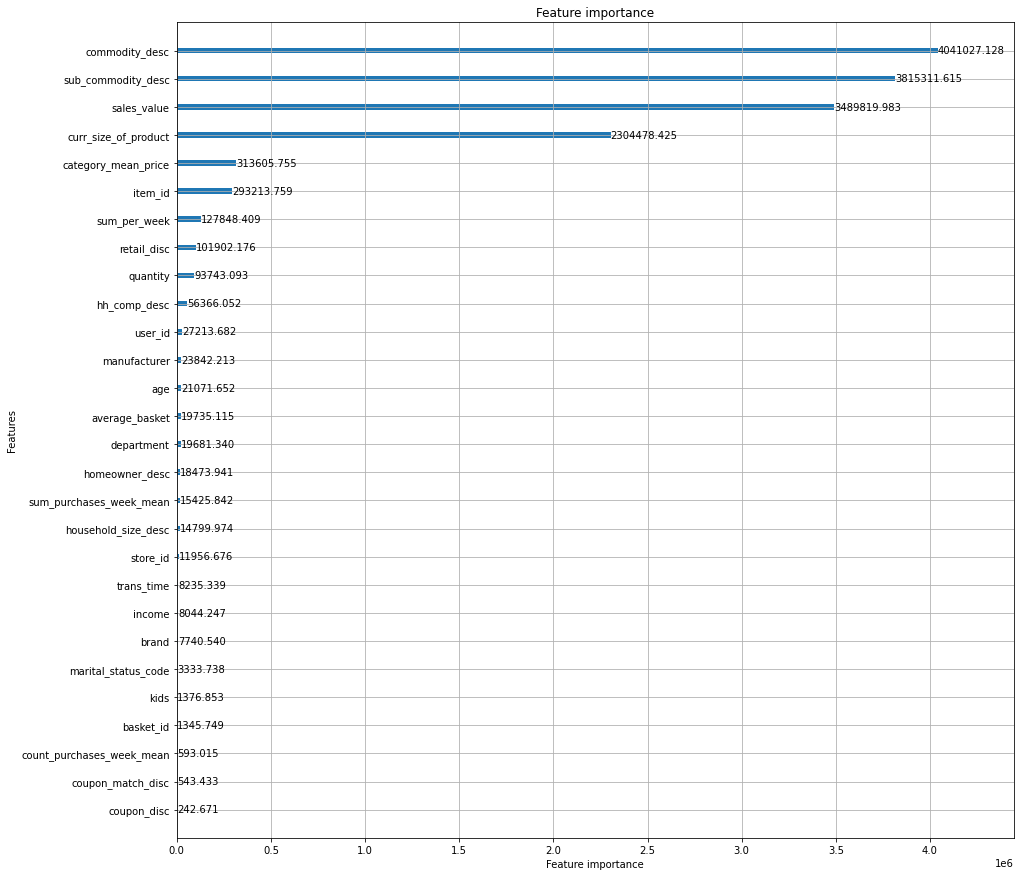

In [28]:
plot_importance(lgb, figsize=(15, 15), importance_type='gain')

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)